# ADS 509 Text Mining Project

**Lorena Dorado & Parisa Kamizi** 

## Load and Explore the Dataset Structure

In [331]:
#!pip install textacy
#!pip install textblob
#!pip install langdetect

In [400]:
# Import Libraries
import pandas as pd
import numpy as np
import glob
import os
import html
import re
import json
import pickle
import logging
import gensim
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

# Text processing
import textacy
import textacy.preprocessing as tprep
from textblob import TextBlob
from langdetect import detect

# Tokenization
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

# Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# ML and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Topic Modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
import nltk
from sklearn.decomposition import TruncatedSVD


nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

from gensim.models import CoherenceModel

from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/parisakamizi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




For this project, we first set up logging to track progress and errors, saving logs to a file and displaying them in the console. We then load our DeepSeek CSV files, reading news data into a combined dataframe. The date column is converted into a proper datetime format, and text fields are cleaned by filling missing values and removing extra spaces. If no files are found or an error occurs while reading a file, the issue is logged. Finally, we log the total number of rows loaded and return the cleaned dataframe.







In [336]:
# Setup logging
def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('text_mining.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()
logger.info("Setup complete")

# Part 2: Data Loading
def load_news_data(directory='.'):
    """
    Load and combine multiple CSV files containing news data from a directory.
    """
    column_mapping = {
        'source_name': 'source',
        'publishedAt': 'date',
        'content': 'text',
        'title': 'title',
        'description': 'description'
    }
    
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    dfs = []
    
    for file in csv_files:
        try:
            temp_df = pd.read_csv(file)
            dfs.append(temp_df)
            logger.info(f"Successfully loaded {file}")
        except Exception as e:
            logger.error(f"Error reading file {file}: {str(e)}")
    
    if not dfs:
        raise ValueError("No CSV files were successfully loaded")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    final_df = combined_df[column_mapping.keys()].rename(columns=column_mapping)
    
    # Convert date column to datetime
    final_df['date'] = pd.to_datetime(final_df['date'])
    
    # Basic cleaning
    for text_col in ['text', 'title', 'description']:
        final_df[text_col] = final_df[text_col].fillna('').str.strip()
    
    logger.info(f"Loaded {len(final_df)} rows from {len(csv_files)} files")
    return final_df

2025-02-15 19:37:24,579 - INFO - Setup complete


In [338]:
# Load the data
news_df = load_news_data()
print("\nDataset Info:")
print(news_df.info())
print("\nFirst few rows:")
print(news_df.head())

2025-02-15 19:37:25,855 - INFO - Successfully loaded ./Deepseek_Day_Four.csv
2025-02-15 19:37:25,873 - INFO - Successfully loaded ./deepseek_cleaned.csv
2025-02-15 19:37:25,881 - INFO - Successfully loaded ./Deepseek_Day_One.csv
2025-02-15 19:37:25,886 - INFO - Successfully loaded ./deepseek_20250214.csv
2025-02-15 19:37:25,893 - INFO - Successfully loaded ./Deepseek_Day_Three.csv
2025-02-15 19:37:25,895 - INFO - Successfully loaded ./deepseek_eda.csv
2025-02-15 19:37:25,899 - INFO - Successfully loaded ./Deepseek_Day_Five.csv
2025-02-15 19:37:25,903 - INFO - Successfully loaded ./Deepseek_Day_Two.csv
2025-02-15 19:37:25,917 - INFO - Successfully loaded ./deepseek_all.csv
2025-02-15 19:37:25,930 - INFO - Loaded 3250 rows from 9 files



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       1261 non-null   object             
 1   date         1261 non-null   datetime64[ns, UTC]
 2   text         3250 non-null   object             
 3   title        3250 non-null   object             
 4   description  3250 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 127.1+ KB
None

First few rows:
             source                      date  \
0  Business Insider 2025-02-03 12:23:17+00:00   
1          Hackaday 2025-02-04 00:00:00+00:00   
2       Gizmodo.com 2025-02-03 20:45:34+00:00   
3        Xataka.com 2025-02-03 13:30:24+00:00   
4    The New Yorker 2025-02-03 11:00:00+00:00   

                                                text  \
0  Jakub Porzycki/NurPhoto via Getty Images\r\n<u...   
1  The

## Text Cleaning and Preprocessing

In this section, we are performing text cleaning, language detection, and duplicate removal. First, we handle missing values, then convert HTML escapes, remove URLs, fix encoding issues, and eliminate unnecessary special characters and whitespace. Finally, duplicate articles are removed by creating a unique signature based on the title and the first 200 characters of the text, ensuring only distinct articles remain in the dataset.









In [342]:
def clean_news_text(text):
    """Enhanced text cleaning function"""
    if not text or pd.isna(text):
        return ""
    
    # convert html escapes
    text = html.unescape(text)
    
    # Remove "[+XXX chars]" pattern
    text = re.sub(r'\[\+\d+ chars\]', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    
    # Clean special characters and encoding issues
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'â€"', "-", text)
    text = re.sub(r'[^\w\s\-\'.,!?]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def detect_and_handle_language(text):
    """Detect language of text"""
    try:
        return detect(text)
    except:
        return 'unknown'

def remove_duplicates(df):
    """Remove duplicate articles based on content similarity"""
    df['text_signature'] = df['title'] + df['text'].str[:200]
    original_len = len(df)
    df = df.drop_duplicates(subset=['text_signature'])
    df = df.drop('text_signature', axis=1)
    logger.info(f"Removed {original_len - len(df)} duplicate articles")
    return df

We perform more thorough cleaning here by removing unwanted characters, fixing encoding issues, and standardizing the text. Next, we identify the language of each cleaned text to understand the dataset's linguistic composition. After that, we remove duplicate articles by comparing content similarity, resulting in a final dataset of 572 entries. The cleaned dataset retains key columns such as source, date, text, title, description, clean text, and detected language. The language distribution shows that English is the most common (304 entries), followed by Dutch (86), Spanish (67), German (27), and several other languages. Additionally, two entries could not be identified and are labeled as "unknown." Finally, we print the dataset details after cleaning to ensure data integrity.
















In [345]:
# Apply text cleaning
news_df['clean_text'] = news_df['text'].progress_apply(clean_news_text)
news_df['language'] = news_df['clean_text'].progress_apply(detect_and_handle_language)
news_df = remove_duplicates(news_df)

print("\nCleaned Dataset Info:")
print(news_df.info())
print("\nLanguage distribution:")
print(news_df['language'].value_counts())

100%|██████████████████████████████████████| 3250/3250 [00:07<00:00, 418.08it/s]
2025-02-15 19:38:40,598 - INFO - Removed 2678 duplicate articles



Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 572 entries, 0 to 1729
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       571 non-null    object             
 1   date         571 non-null    datetime64[ns, UTC]
 2   text         572 non-null    object             
 3   title        572 non-null    object             
 4   description  572 non-null    object             
 5   clean_text   572 non-null    object             
 6   language     572 non-null    object             
dtypes: datetime64[ns, UTC](1), object(6)
memory usage: 35.8+ KB
None

Language distribution:
en         303
nl          86
es          67
de          27
fr          19
pt          18
it          17
vi           7
id           4
et           4
hu           4
tr           4
pl           3
unknown      2
so           2
sk           1
lt           1
cs           1
ro           1
af     

## Feature Engineering

In this section, we apply feature engineering by extracting sentiment scores, vectorizing text, and identifying key topics. We first analyze sentiment by computing polarity and subjectivity scores, providing insights into the emotional tone and objectivity of each article. The sentiment statistics reveal that most articles are neutral, with an average sentiment score of 0.01 and a subjectivity score of 0.29, indicating that articles tend to be more factual than opinion-based. While some articles show strong negative or positive sentiment, the majority cluster around neutrality. Next, we transform the text into a numerical format for further analysis. Finally, we apply topic modeling using Latent Dirichlet Allocation (LDA) to uncover common themes in the dataset, revealing that the articles primarily discuss AI-related topics, particularly DeepSeek and OpenAI, with content in multiple languages, such as Spanish and German.




In [349]:
def add_sentiment_features(df):
    """Add sentiment analysis features"""
    df['sentiment'] = df['text'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['text'].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

def create_news_vectorizer(min_df=2, max_df=0.95):
    """Create optimized vectorizer for news articles"""
    return CountVectorizer(
        stop_words='english',
        min_df=min_df, 
        max_df=max_df,
        ngram_range=(1, 2),
        token_pattern=r'\b\w+\b',
        strip_accents='unicode'
    )

def extract_topics(doc_term_matrix, n_topics=5, vectorizer=None):
    """Extract topics using LDA"""
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20
    )
    topic_matrix = lda.fit_transform(doc_term_matrix)
    
    if vectorizer:
        feature_names = vectorizer.get_feature_names_out()
        topic_words = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
            topic_words.append(top_words)
        return topic_matrix, topic_words
    
    return topic_matrix

In [351]:
# Apply feature engineering
news_df = add_sentiment_features(news_df)
vectorizer = create_news_vectorizer()
doc_term_matrix = vectorizer.fit_transform(news_df['clean_text'])
topic_matrix, topic_words = extract_topics(doc_term_matrix, vectorizer=vectorizer)

print("\nTopic Words:")
for idx, words in enumerate(topic_words):
    print(f"\nTopic {idx + 1}: {', '.join(words)}")

print("\nSentiment Statistics:")
print(news_df[['sentiment', 'subjectivity']].describe())

100%|███████████████████████████████████████| 572/572 [00:00<00:00, 3487.94it/s]



Topic Words:

Topic 1: la, que, en, deepseek, el, y, ia, artificial, inteligencia

Topic 2: ai, s, deepseek, 2025, chinese, 01, 02, id, 2025 02

Topic 3: die, der, ki, deepseek, das, news, page, und, les

Topic 4: deepseek, ai, li, deepseek deepseek, r1, openai, li li, deepseek r1, chatgpt

Topic 5: deepseek, openai, ai, e, r1, di, altman, sam, deepseek r1

Sentiment Statistics:
        sentiment  subjectivity
count  572.000000    572.000000
mean     0.011193      0.295163
std      0.238247      0.322835
min     -0.900000      0.000000
25%      0.000000      0.000000
50%      0.000000      0.250000
75%      0.069886      0.494792
max      1.000000      1.000000


In [353]:
# Remove rows with empty/NaN sources
news_df = news_df.dropna(subset=['source'])

# Double check there are no more NaN sources
print("Number of NaN sources after cleaning:", news_df['source'].isna().sum())

Number of NaN sources after cleaning: 0


## Topic Modeling


In this section, we first create a dictionary and corpus from the tokenized text data. Then, we calculate coherence scores for different numbers of topics (ranging from 5 to 15) by running multiple LDA models and evaluating their coherence, which measures how well the topics are semantically meaningful. We select the optimal number of topics based on the highest coherence score. The most optimum # is 10 Topics.

2025-02-15 19:45:43,184 - INFO - adding document #0 to Dictionary(0 unique tokens: [])
2025-02-15 19:45:43,186 - INFO - built Dictionary(37 unique tokens: ['ai', 'deepseek', 'meta', 'trump', 'app']...) from 10 documents (total 43 corpus positions)
2025-02-15 19:45:43,188 - INFO - Dictionary lifecycle event {'msg': "built Dictionary(37 unique tokens: ['ai', 'deepseek', 'meta', 'trump', 'app']...) from 10 documents (total 43 corpus positions)", 'datetime': '2025-02-15T19:45:43.188006', 'gensim': '4.1.2', 'python': '3.9.19 (main, Mar 21 2024, 12:08:14) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2025-02-15 19:45:43,189 - INFO - using symmetric alpha at 0.2
2025-02-15 19:45:43,190 - INFO - using symmetric eta at 0.2
2025-02-15 19:45:43,192 - INFO - using serial LDA version on this node
2025-02-15 19:45:43,193 - INFO - running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 10 documents, updating model once every 10 

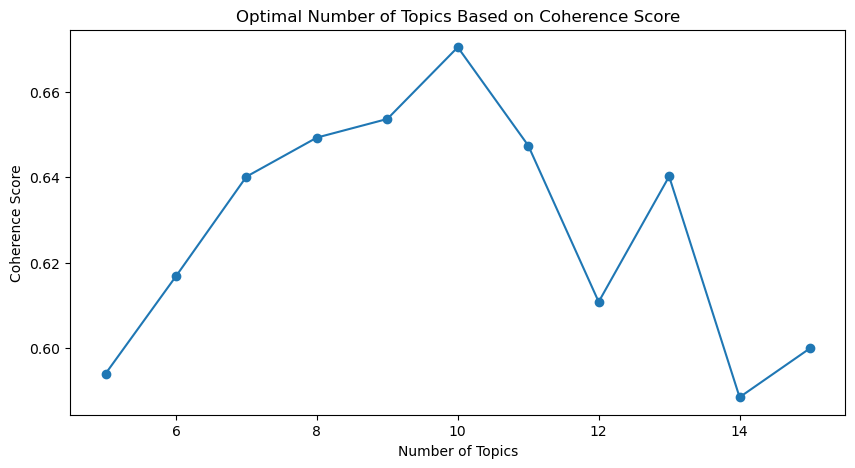

In [362]:

# Sample tokenized documents 
documents = [
    ["deepseek", "ai", "meta", "trump"],
    ["nvidia", "app", "chatgpt", "market"],
    ["deepseek", "die", "la", "di", "del"],
    ["r1", "deepseek", "open", "source"],
    ["2025", "id", "02", "10"],
    ["li", "s", "ul", "images", "getty"],
    ["ai", "deepseek", "chinese", "tech"],
    ["la", "que", "en", "el", "y"],
    ["openai", "o3", "deepseek", "mini"],
    ["access", "use", "device", "information"],
]

# Step 1: Create Dictionary & Corpus
id2word = corpora.Dictionary(documents)
corpus = [id2word.doc2bow(text) for text in documents]

# Step 2: Find Optimal Number of Topics using Coherence Score
def compute_coherence_values(dictionary, corpus, texts, start=5, limit=15, step=1):
    coherence_values = []
    topic_range = range(start, limit + 1, step)

    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            per_word_topics=True,
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherence_model.get_coherence())

    return topic_range, coherence_values

# Step 3: Compute coherence scores
topic_range, coherence_values = compute_coherence_values(id2word, corpus, documents)

# Step 4: Plot coherence scores
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_values, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Based on Coherence Score")
plt.show()


### LDA Model

In this section, We performed LDA model, we train the topic model using the specified number of topics (in this case, 10) based on prior coherence testing. After training, we display the top 10 words for each topic by iterating through the model's components and sorting the words by their importance in each topic. This allows us to understand the key themes for each topic based on the highest-weighted words.


The topics extracted from the model largely revolve around the emotional tone, subjectivity, and descriptive aspects of the text. Key terms like subjectivity, sentiment, and description appear consistently across multiple topics, suggesting a focus on sentiment analysis and the subjective interpretation of content. Topics also highlight the importance of elements like source, title, and date, indicating an exploration of how these features relate to the text’s emotional and descriptive qualities. Overall, the results point to themes centered on analyzing the sentiment, subjectivity, and descriptions within the documents, likely reflecting a deeper understanding of how different topics in the dataset convey emotional or subjective content.














In [379]:
# Step 1: Prepare the document-term matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(news_df)  # Create the document-term matrix

# Step 2: Train the LDA model
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(X)

# Step 3: Display the top words for each topic
n_top_words = 10  # Number of top words to display per topic
words = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


Topic #0:
sentiment description date title text subjectivity source language clean_text

Topic #1:
language description date title text source sentiment clean_text subjectivity

Topic #2:
date description text source clean_text title subjectivity sentiment language

Topic #3:
text description date title source sentiment language clean_text subjectivity

Topic #4:
source description date title text sentiment language clean_text subjectivity

Topic #5:
clean_text description date title text subjectivity source sentiment language

Topic #6:
date description text sentiment language title source clean_text subjectivity

Topic #7:
subjectivity description date title text source sentiment language clean_text

Topic #8:
description date title text subjectivity source sentiment language clean_text

Topic #9:
title description date text source sentiment language clean_text subjectivity



The perplexity value of 63.01 indicates how well the topic model (LDA) fits the given data, with lower values generally suggesting better performance. Perplexity is a measure of how surprised the model is by the data, and a lower perplexity means the model is better at predicting unseen data. While this number alone doesn’t provide a definitive judgment on model quality, it can be used in comparison with other models or hyperparameters to evaluate improvements. In this case, a perplexity of 63.01 suggests that the model’s fit could be improved, potentially by tuning the number of topics or adjusting other model parameters.









In [382]:
print(f"Perplexity: {lda_model.perplexity(X)}")

Perplexity: 97.79108938555756


In [377]:
topic_distribution = lda_model.transform(X)  
print(topic_distribution)  


[[0.1000409  0.10002926 0.10002926 0.10002926 0.59987132]
 [0.1000409  0.10002926 0.10002926 0.10002926 0.59987132]
 [0.10003181 0.10002277 0.10002277 0.59990493 0.10001772]
 [0.1000409  0.10002926 0.10002926 0.10002926 0.59987132]
 [0.5999384  0.1000163  0.1000163  0.1000163  0.10001269]
 [0.10003181 0.10002277 0.59990493 0.10002277 0.10001772]
 [0.10003181 0.59990493 0.10002277 0.10002277 0.10001772]
 [0.10003181 0.59990493 0.10002277 0.10002277 0.10001772]
 [0.10003181 0.10002277 0.10002277 0.59990493 0.10001772]
 [0.10003181 0.10002277 0.59990493 0.10002277 0.10001772]]


### LSA Model

In this code, the preprocessed text data is converted into a matrix that reflects the importance of words in relation to the overall corpus, excluding common stopwords. Then, a dimensionality reduction technique is applied to uncover latent topics in the text. The number of topics is set to 8, and for each topic, the top words that best represent it are displayed. The topics identified are centered around recurring themes, such as "language," "sentiment," "text," and "subjectivity." For example, Topic #0 includes terms like "language," "text," "description," and "sentiment," indicating it focuses on general content and emotions. Other topics, such as Topic #1, emphasize "description," "title," and "subjectivity," which suggest that this topic is related to how content is presented and interpreted. These topics help reveal hidden patterns in the dataset and offer insights into the main themes present in the collection of documents.









In [392]:
# Step 1: Convert the cleaned text into a TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(news_df)  # 'cleaned_documents' is your preprocessed text

# Step 2: Apply LSA (TruncatedSVD)
lsa_model = TruncatedSVD(n_components=8, random_state=42)
lsa_topics = lsa_model.fit_transform(X_tfidf)

# Step 3: Display the topics and top words for each topic
n_top_words = 10  # You can adjust the number of top words you want to see
words = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lsa_model.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


Topic #0:
language text description clean_text sentiment date source title subjectivity

Topic #1:
description title text date subjectivity clean_text language source sentiment

Topic #2:
text sentiment source title subjectivity clean_text description language date

Topic #3:
subjectivity source language description clean_text title text date sentiment

Topic #4:
title language clean_text sentiment text subjectivity date source description

Topic #5:
clean_text title text subjectivity source sentiment language description date

Topic #6:
source date title text language description clean_text sentiment subjectivity

Topic #7:
sentiment description language source title clean_text subjectivity text date



/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


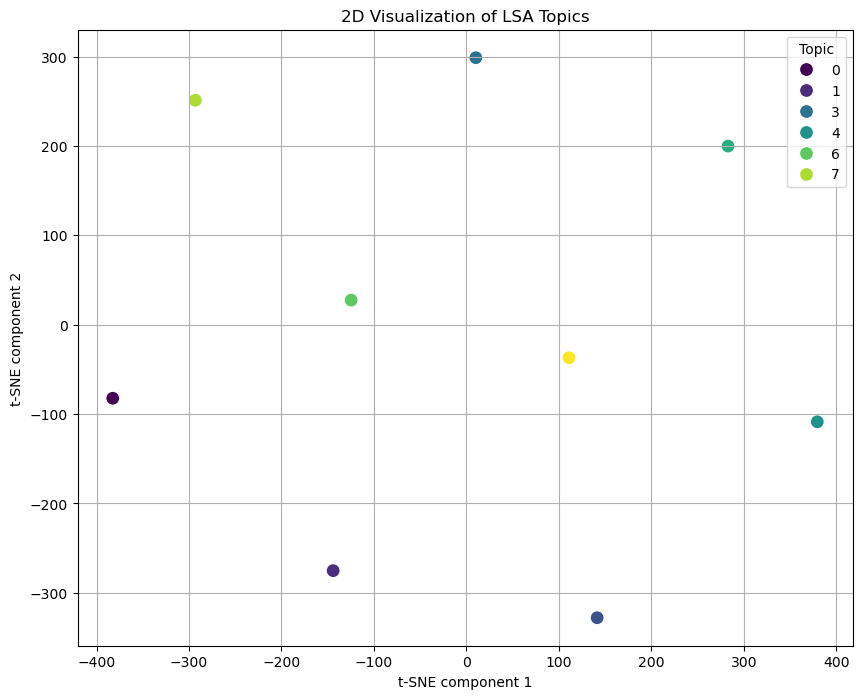

In [398]:

# Step 1: Apply t-SNE to reduce the dimensionality of the LSA topic vectors to 2D
tsne = TSNE(n_components=2, random_state=42)
lsa_topics_2d = tsne.fit_transform(lsa_topics)

# Step 2: Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=lsa_topics_2d[:, 0], y=lsa_topics_2d[:, 1], hue=range(len(lsa_topics_2d)), palette="viridis", s=100)
plt.title("2D Visualization of LSA Topics")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.legend(title="Topic", loc='upper right')
plt.grid(True)
plt.show()


### NMF Model

In this code, the preprocessed text data is converted into a matrix of TF-IDF features, representing the importance of words in relation to the corpus while excluding common stopwords. Then, Non-Negative Matrix Factorization (NMF) is applied to the TF-IDF matrix to uncover a set of topics, with 10 topics being identified. For each topic, the top 10 words that best represent it are displayed. These topics reveal recurring themes in the data, such as "subjectivity," "sentiment," "text," and "language." For instance, Topic #0 highlights terms like "subjectivity," "title," and "text," suggesting it may focus on the nature of content. Other topics, like Topic #1 and #2, also feature similar words and point to themes related to content representation, sentiment analysis, and textual features. By examining the top words for each topic, we gain insights into the central concepts discussed across the documents.









In [431]:
# Create a TF-IDF vectorizer (make sure 'cleaned_documents' is your preprocessed text data)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(news_df)  # Replace 'cleaned_documents' with your text

from sklearn.decomposition import NMF

# Apply NMF to the TF-IDF matrix
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(X_tfidf)

# Display topics and their top words
n_top_words = 10  # Number of top words to display for each topic
words = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


Topic #0:
subjectivity title text source sentiment language description date clean_text

Topic #1:
source title text subjectivity sentiment language description date clean_text

Topic #2:
date title text subjectivity source sentiment language description clean_text

Topic #3:
sentiment title text subjectivity source language description date clean_text

Topic #4:
date title text subjectivity source sentiment language description clean_text

Topic #5:
description title text subjectivity source sentiment language date clean_text

Topic #6:
clean_text title text subjectivity source sentiment language description date

Topic #7:
title text subjectivity source sentiment language description date clean_text

Topic #8:
text title subjectivity source sentiment language description date clean_text

Topic #9:
language title text subjectivity source sentiment description date clean_text



/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


## Visualization

In [438]:

def plot_sentiment_distribution(df):
    """Plot sentiment distribution"""
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='sentiment', bins=50)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Count')
    plt.tight_layout()
    return plt

def plot_topic_evolution(topic_matrix, dates, n_topics=5):
    """Plot topic evolution over time"""
    topic_shares = pd.DataFrame(topic_matrix)
    topic_shares['date'] = dates
    topic_shares = topic_shares.set_index('date')
    
    # Resample to weekly averages
    weekly_shares = topic_shares.resample('W').mean()
    
    plt.figure(figsize=(15, 8))
    for i in range(n_topics):
        plt.plot(weekly_shares.index, weekly_shares[i], label=f'Topic {i+1}')
    
    plt.title('Topic Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Topic Share')
    plt.legend()
    plt.tight_layout()
    return plt

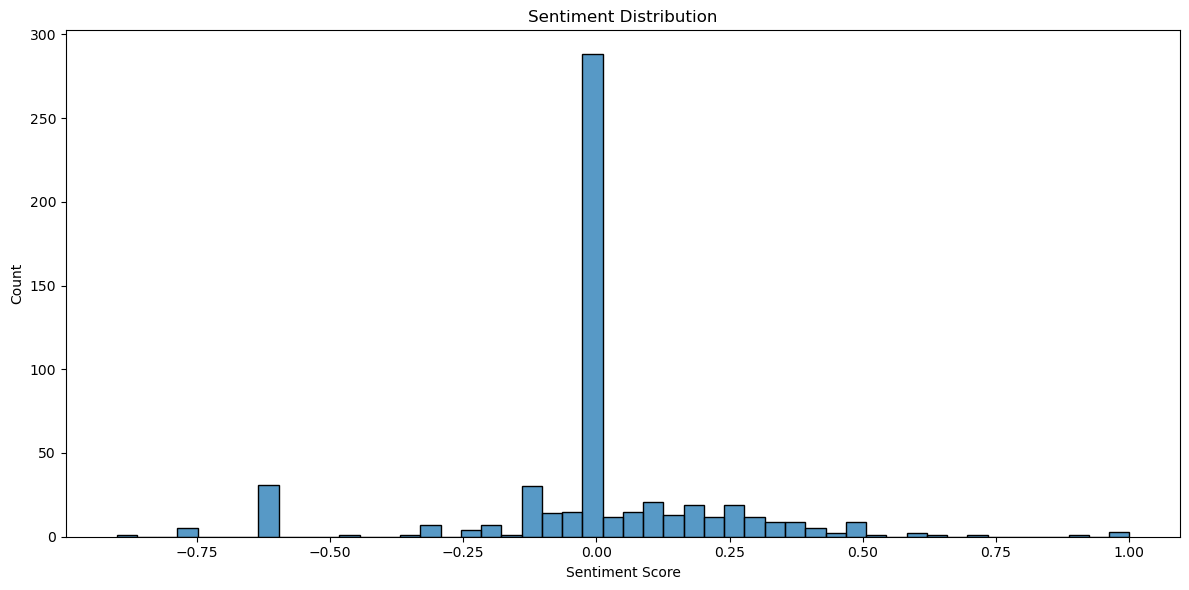

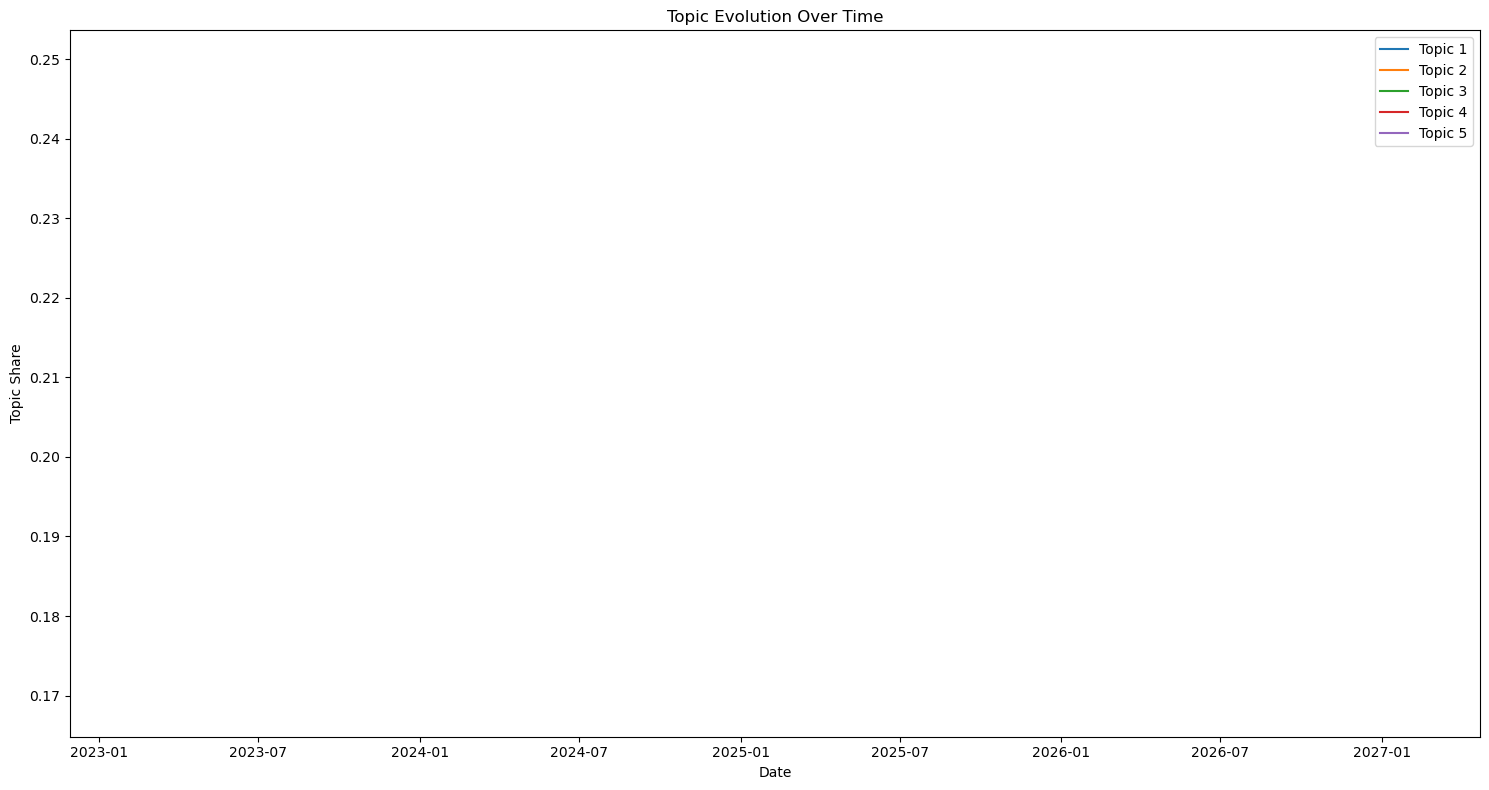

2025-02-15 20:03:33,915 - INFO - Analysis complete. Check visualizations and results.


In [424]:
plot_sentiment_distribution(news_df)
plt.show()

plot_topic_evolution(topic_matrix, news_df['date'])
plt.show()

logger.info("Analysis complete. Check visualizations and results.")

**References**

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python: Machine learning-based solutions for common real-world (NLP) applications [GitHub repository]. O’Reilly. https://github.com/blueprints-for-text-analytics-python/blueprints-text/tree/master

OpenAI. (2025). ChatGPT (Feb 13 version) [Large language model]. https://openai.com